# Modular variables

In [1]:
from IPython import get_ipython
if get_ipython():
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import pandas as pd
import torch

import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

import collections

import latenta as la
la.logger.setLevel("INFO")

## Simple example

In [2]:
n_cells = 50
cell_ids = [str(i) for i in range(n_cells)]
cells = la.Dim(pd.Series(cell_ids, name = "cell"))

x = la.Fixed(pd.Series(np.random.uniform(0, 3, n_cells), index = cells.index), label = "x")

In [3]:
n_genes = 100
genes = la.Dim(pd.Series([str(i) for i in range(n_genes)]), id = "gene")

def random_coefficient(n_genes):
    return np.random.choice([-1, 1], n_genes) * np.random.normal(3., 1., n_genes) * (np.random.random(n_genes) > 0.5)

slope = la.Fixed(pd.Series(random_coefficient(n_genes), index = genes.index), label = "slope")
intercept = la.Fixed(pd.Series(random_coefficient(n_genes), index = genes.index), label = "intercept")
final = la.Fixed(pd.Series(random_coefficient(n_genes), index = genes.index), label = "final")

slope_subset = la.Fixed(pd.Series(random_coefficient(10), index = genes.index[:10]), label = "slope_subset")

In [4]:
y_linear = la.links.scalar.Linear(x = x, a = slope)
y = la.modular.Additive(linear = y_linear, definition = y_linear.value_definition, subsettable = ("gene", ))

We can add extra terms:

In [5]:
y_sigmoid = la.links.scalar.Sigmoid(x = x, a = final)
y.sigmoid = y_sigmoid

y_exponential = la.links.scalar.Exp(x = x, a = final)
y.exponential = y_exponential

The terms can have a subset of the modular variable's dimensions:

In [6]:
y.simply_x = x
y.simply_slope = slope

In fact, a terms dimension can be a subset, as long as this dimension was registered as "subsettable" when defining the modular variable:

In [7]:
y_linear_subset = la.links.scalar.Linear(x = x, a = slope_subset)
y.linear_subset = y_linear_subset
y_linear.prior_xr().shape, y_linear_subset.prior_xr().shape

((50, 100), (50, 10))

We can also remove terms

In [8]:
del y.exponential

In [9]:
scale = la.Fixed(pd.Series(np.random.uniform(1., 1.2, n_genes), index = genes.index), label = "scale")
dist = la.distributions.Normal(loc = y, scale = scale)


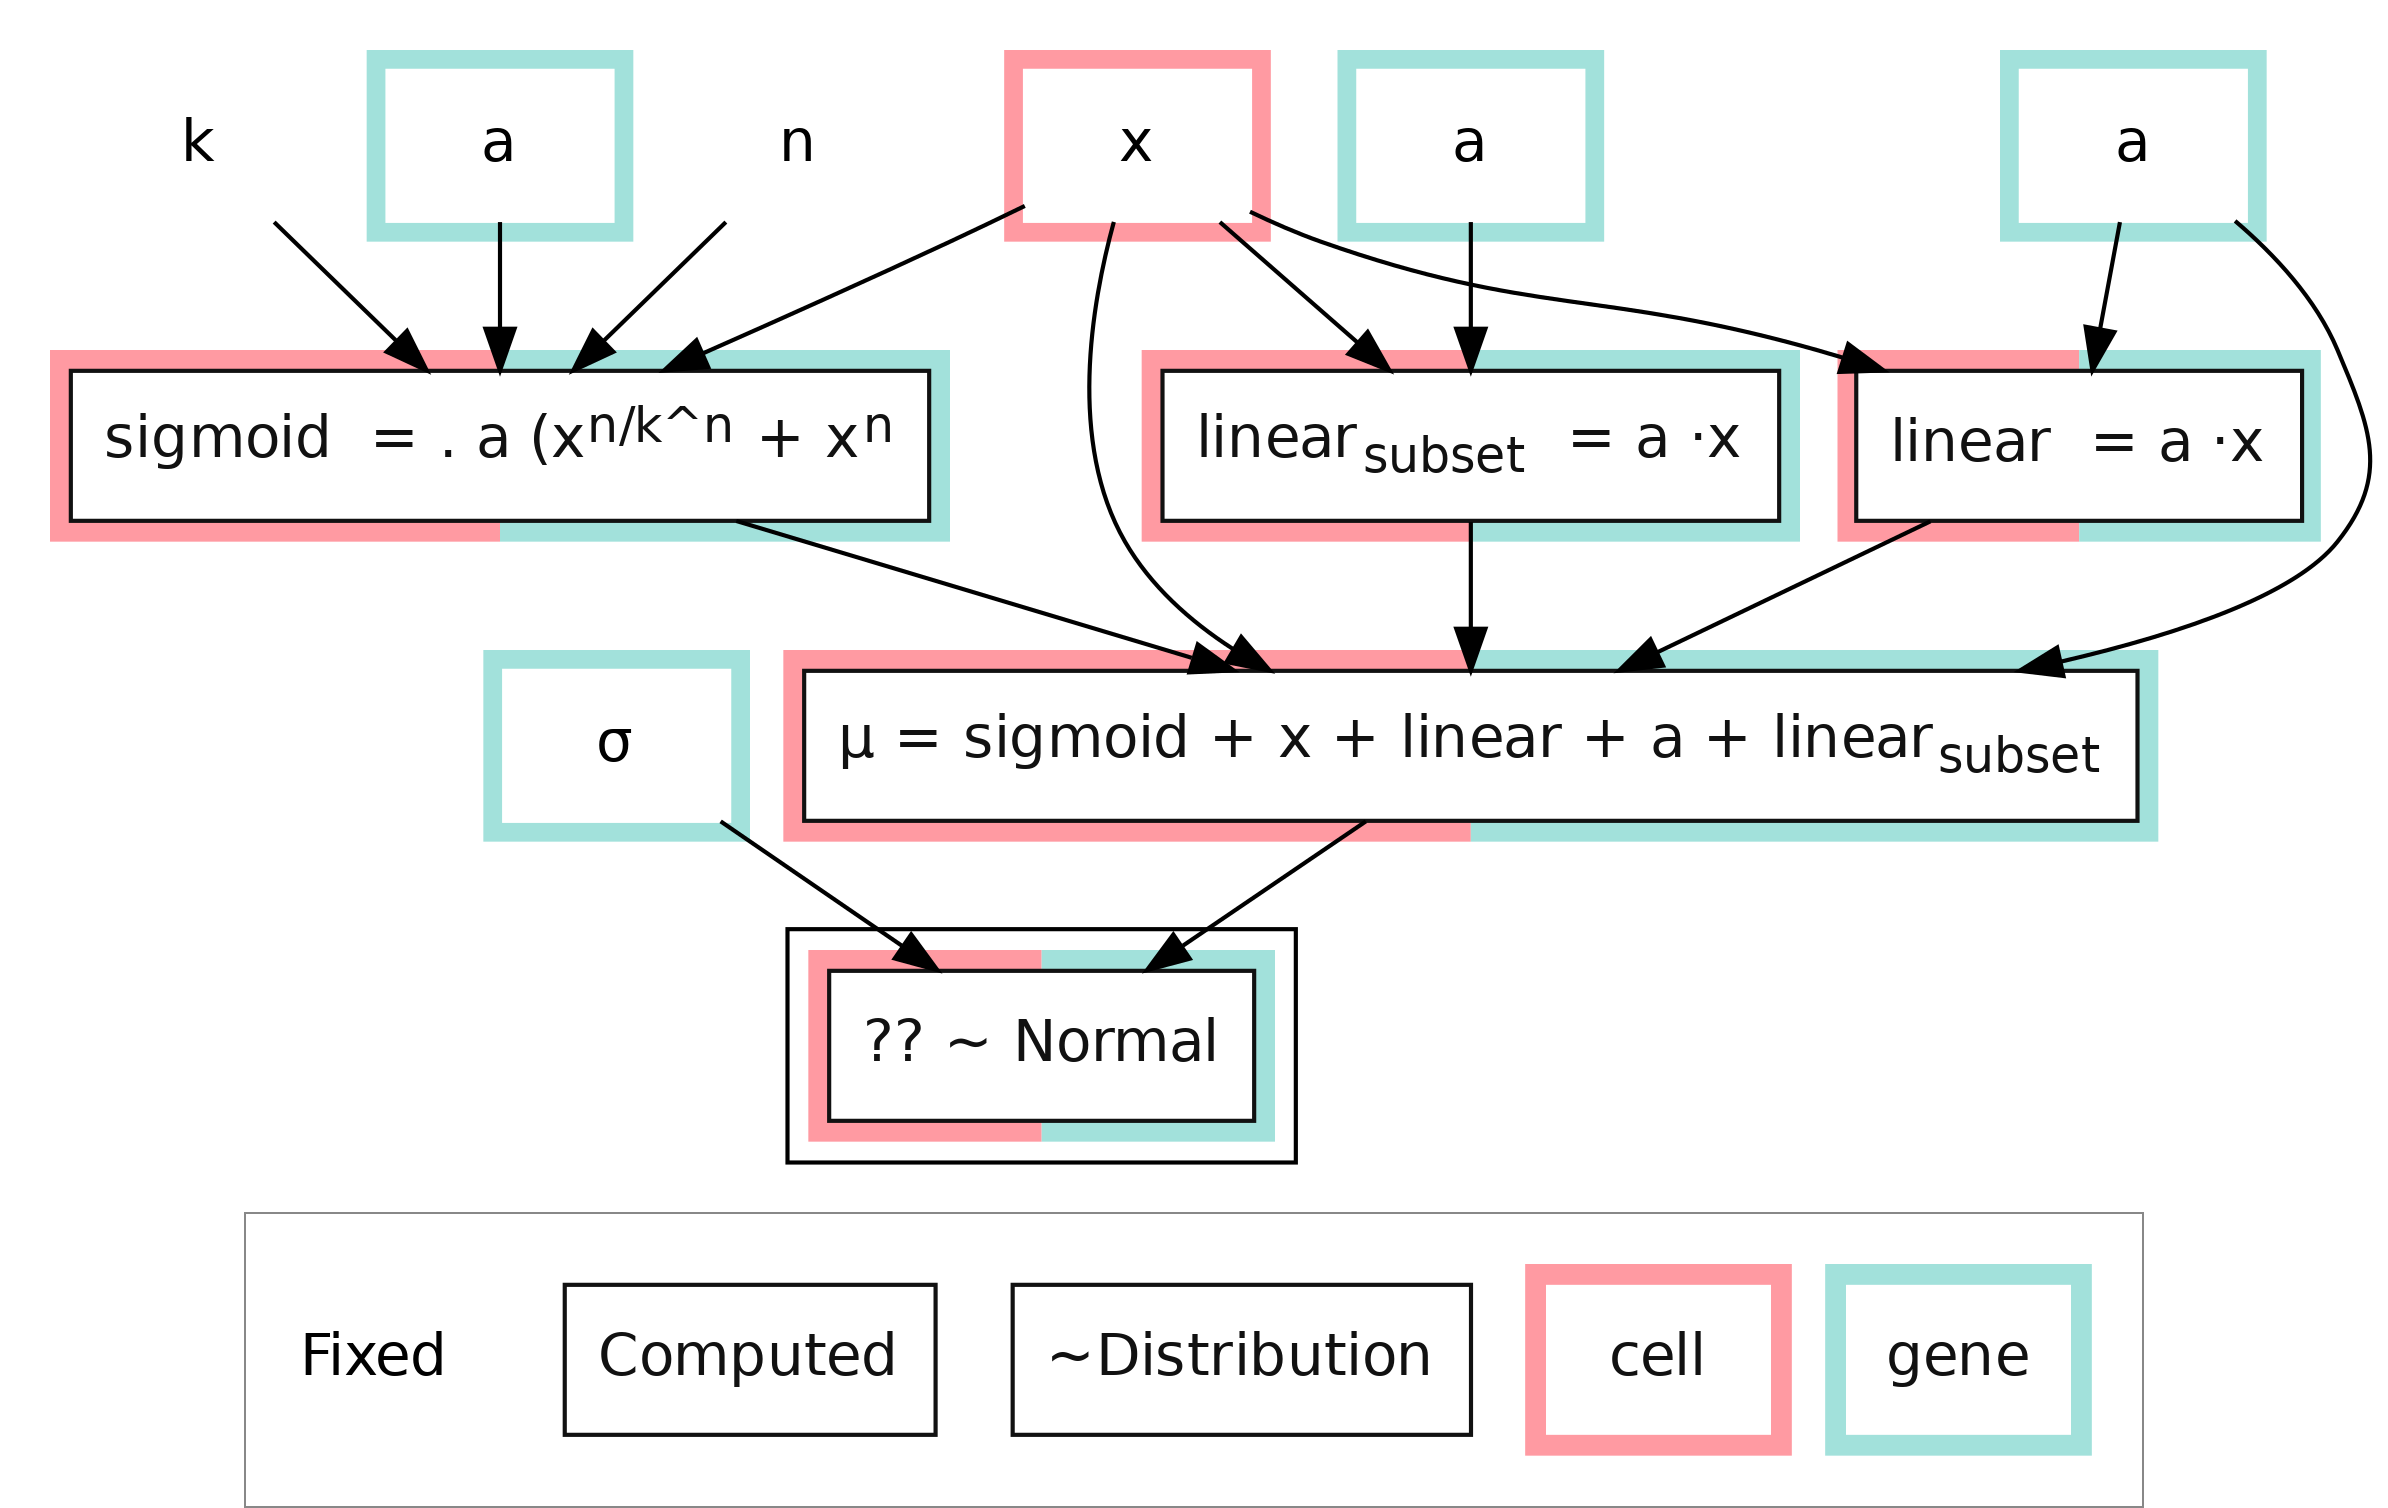

In [10]:
model_gs = la.Model(dist, label = "ground truth", symbol = "gs")
model_gs.plot()

In [11]:
posterior = la.posterior.Posterior(dist)
posterior.sample(1)

  0%|          | 0/1 [00:00<?, ?it/s]

<AxesSubplot:xlabel='gene', ylabel='cell'>

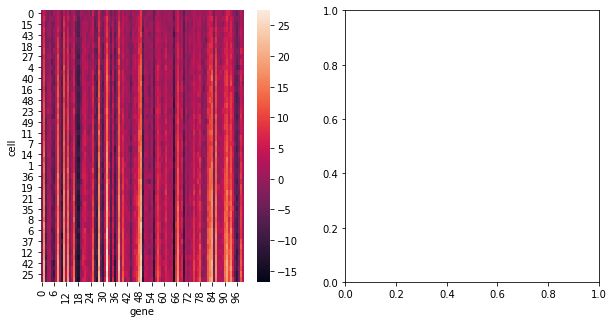

In [12]:
observation_value = posterior.samples[dist].sel(sample = 0).to_pandas()
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 5))
cell_order = model_gs.find_recursive("x").prior_pd().sort_values().index
sns.heatmap(observation_value.loc[cell_order], ax = ax0)

## Types of modular variables

In [13]:
y = la.modular.Multiplicative(linear = y_linear, linear_subset = y_linear_subset, definition = y_linear.value_definition, subsettable = ("gene", ))

In [14]:
y.prior_pd()

gene,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,,,,,,,,,,,,,,,,,,,,,
0,-0.0,0.0,-0.0,-0.115656,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,0.419655,0.656980,0.506566,0.528469,0.0,-0.332996,-0.489473,0.0,0.526292,0.0
1,-0.0,0.0,-0.0,-14.155768,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,4.642752,7.268336,5.604265,5.846588,0.0,-3.684013,-5.415167,0.0,5.822501,0.0
2,-0.0,0.0,-0.0,-2.333124,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,1.884853,2.950782,2.275206,2.373584,0.0,-1.495627,-2.198437,0.0,2.363806,0.0
3,-0.0,0.0,-0.0,-28.771868,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,6.619005,10.362207,7.989801,8.335272,0.0,-5.252166,-7.720211,0.0,8.300932,0.0
4,-0.0,0.0,-0.0,-4.378821,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,2.582185,4.042470,3.116955,3.251729,0.0,-2.048958,-3.011783,0.0,3.238332,0.0
5,-0.0,0.0,-0.0,-6.744246,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,3.204612,5.016894,3.868287,4.035547,0.0,-2.542852,-3.737764,0.0,4.018922,0.0
6,-0.0,0.0,-0.0,-25.919979,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,6.282406,9.835254,7.583492,7.911395,0.0,-4.985076,-7.327611,0.0,7.878801,0.0
7,-0.0,0.0,-0.0,-11.084132,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,4.108275,6.431601,4.959099,5.173525,0.0,-3.259908,-4.791770,0.0,5.152212,0.0
8,-0.0,0.0,-0.0,-23.872503,0.0,-0.0,-0.0,-0.0,0.0,0.0,...,6.029172,9.438809,7.277813,7.592498,0.0,-4.784135,-7.032247,0.0,7.561219,0.0
